# Does being married have an effect on your political views?

Politics has often been a polarizing subject amongst Americans, and in today's [increasingly partisan](https://www.nytimes.com/2014/06/16/opinion/charles-blow-politics-grow-more-partisan-than-ever.html) political environment, that has not changed. Using data from the [General Social Survey (GSS)](https://gssdataexplorer.norc.org/), an annual study designed and conducted by the [National Opinion Research Center (NORC)](http://www.norc.org/Pages/default.aspx) at the University of Chicago, we identify variables that are correlated with a person's political views. We find that while marital status has a statistically significant apparent effect on political views, that apparent effect is drastically reduced when including confounding variables, particularly religion. To see more analysis, check out the [full report](https://github.com/williamalu/data_science_politics/blob/master/report3.md).

First, let's import some data and necessary packages.

In [1]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from IPython.display import display

import thinkstats2_mod
import thinkplot

import statsmodels.formula.api as smf

In [2]:
dct = thinkstats2_mod.ReadStataDct('GSS/GSS.dct')
df = dct.ReadFixedWidth('GSS/GSS.dat')
print('Total number of respondents: %i' %(df.shape[0] + 1))

Total number of respondents: 62467


Now, let's select for years where we have data while filtering out respondents with "invalid" responses (e.g. no response, refuse to answer, don't know).

In [3]:
# Filter out years without relevant data
df = df[df.year >= 1974]
print('Number of respondents left: %i' %(df.shape[0] + 1))

# Filter out invalid polviews
df = df[df.polviews <= 7]
df = df[df.polviews > 0]

# Center polviews likert scale around 0
df['polviews'] = np.subtract(df['polviews'], 4)
print('Number of respondents left: %i' %(df.shape[0] + 1))

# Filter out invalid age respondants
df = df[df.age <= 89]
print('Number of respondents left: %i' %(df.shape[0] + 1))

# Filter out marital status no answers
df = df[df.marital != 9]
print('Number of respondents left: %i' %(df.shape[0] + 1))

# Filter out highest education degree invalid
df = df[df.degree <= 4]

# Recode religion to make coding more consistent through GSS years
df['relig_recode'] = df.relig
#recode Christians who are not Catholic as '1' (replacing Protestant code)
df.relig_recode.replace([10, 11, 13], 1, inplace=True)
#recode Buddhism, Hinduism, Other eastern, Moslem/islam, Native american, Inter-nondenominational
df.relig_recode.replace([6, 7, 8, 9, 12], 5, inplace=True)
#remove don't know/don't answer respondants
df = df[df.relig_recode <= 5]

# For more information about SEI scores http://gss.norc.org/Documents/reports/methodological-reports/MR074.pdf

df_control = df.copy(deep=True)

Number of respondents left: 59350
Number of respondents left: 53082
Number of respondents left: 52916
Number of respondents left: 52905


Let's visualize the relationship between marital status and political views.

In [4]:
pmf_married   = thinkstats2_mod.Pmf(df_control[df_control.marital == 1].polviews)
pmf_widowed   = thinkstats2_mod.Pmf(df_control[df_control.marital == 2].polviews)
pmf_divorced  = thinkstats2_mod.Pmf(df_control[df_control.marital == 3].polviews)
pmf_separated = thinkstats2_mod.Pmf(df_control[df_control.marital == 4].polviews)
pmf_nmarried  = thinkstats2_mod.Pmf(df_control[df_control.marital == 5].polviews)

In [5]:
def plot_bar(pmf, colors, shift=0, align='center', width=1):
    """
    Plots bar graphs and allows x-axis shifting with thinkstats2 PMF objects.
    pmf:    thinkstats2 pmf object
    colors: list of colors for bars
    shift:  number for x-axis shift (useful for interleaving or plotting multiple pmf objects)
    align:  parameter passed onto plt.bar
    width:  parameter passed onto plt.bar
    """
    x_axis = list(pmf.GetDict().keys())
    y_axis = list(pmf.GetDict().values())

    for i in range(len(x_axis)):
        plt.bar(x_axis[i]+shift, y_axis[i] * 100, align=align, width=width, color=colors[x_axis[i] + 3], edgecolor = "#ffffff")

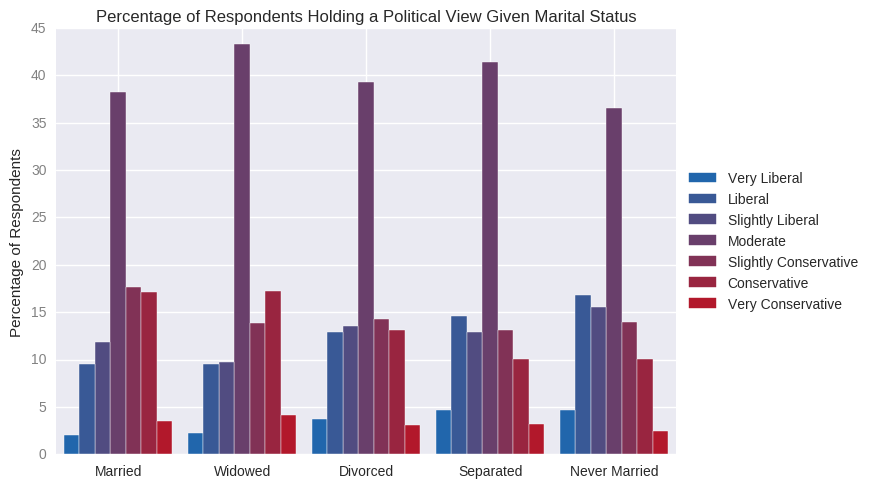

In [6]:
# Make y tick labels gray
ax = plt.axes()
for tick in ax.get_yticklabels():
    tick.set_color('gray')

# Set width of bar plot bars and calculate x-axis shifts
width = 1
shifts = [-width*8*2, -width*8, 0, width*8, width*8*2]

# List PMFs to plot
pmfs_to_plot = [pmf_married, pmf_widowed, pmf_divorced, pmf_separated, pmf_nmarried]

# List of bar colors for bar plot gradient
colors = ['#2166ac', '#395996', '#514C81', '#693F6B', '#813256', '#992540', '#B2182B']

# Create PMF plots
for i in range(len(pmfs_to_plot)):
    plot_bar(pmfs_to_plot[i], colors=colors, shift=shifts[i], width=width)

# Text labels for x-axis and legend
marriage_status = ('Married', 'Widowed', 'Divorced', 'Separated', 'Never Married')
pol_views = ('Very Liberal', 'Liberal', 'Slightly Liberal', 'Moderate', 'Slightly Conservative', 'Conservative', 'Very Conservative')

# Set custom colors for legend that match color gradient in bar graphs
patches = []
for i in range(len(pol_views)):
    patches.append(mpatches.Patch(color=colors[i], label=pol_views[i]))

plt.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(shifts, marriage_status)
plt.ylabel('Percentage of Respondents')
plt.title('Percentage of Respondents Holding a Political View Given Marital Status')
plt.savefig('Plots/marriage_punchline.svg', bbox_inches='tight')
plt.show()

To model this relationship, let's run an initial linear regression with political views as the dependent variable and marital status as the explanatory variable.

In [7]:
formula = 'df_control.polviews ~ df_control.marital'
model = smf.ols(formula, data=df_control)
results = model.fit()
params_marital = results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     df_control.polviews   R-squared:                       0.020
Model:                             OLS   Adj. R-squared:                  0.020
Method:                  Least Squares   F-statistic:                     1089.
Date:                 Tue, 02 May 2017   Prob (F-statistic):          1.89e-236
Time:                         00:10:46   Log-Likelihood:                -91036.
No. Observations:                52664   AIC:                         1.821e+05
Df Residuals:                    52662   BIC:                         1.821e+05
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3831      0.010     36.929      0.000       0.363       0.403
df_control.marital    -0.1208      0.004    -33.004      0.000      -0.128      -0.114
==============================================================================
Omnibus:                      380.059   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              276.011
Skew:                          -0.069   Prob(JB):                     1.16e-60
Kurtosis:                       2.673   Cond. No.                         5.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

To control for more confounding variables, let's run the same regression, but with age, sex, race, education (highest degree of education obtained), class (calculated social economic index), and income as added explanatory variables.

In [8]:
formula = 'df_control.polviews ~ df_control.marital + df_control.age + df_control.sex + df_control.race + df_control.degree + df_control.sei10 + df_control.coninc'
model = smf.ols(formula, data=df_control)
results = model.fit()
params_standard = results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     df_control.polviews   R-squared:                       0.032
Model:                             OLS   Adj. R-squared:                  0.032
Method:                  Least Squares   F-statistic:                     247.0
Date:                 Tue, 02 May 2017   Prob (F-statistic):               0.00
Time:                         00:10:46   Log-Likelihood:                -90724.
No. Observations:                52664   AIC:                         1.815e+05
Df Residuals:                    52656   BIC:                         1.815e+05
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.4147      0.036     11.494      0.000       0.344       0.485
df_control.marital    -0.0909      0.004    -22.581      0.000      -0.099      -0.083
df_control.age         0.0057      0.000     15.520      0.000       0.005       0.006
df_control.sex        -0.0902      0.012     -7.496      0.000      -0.114      -0.067
df_control.race       -0.1373      0.011    -12.283      0.000      -0.159      -0.115
df_control.degree     -0.0650      0.006    -10.134      0.000      -0.078      -0.052
df_control.sei10       0.0002      0.000      0.779      0.436      -0.000       0.001
df_control.coninc   7.132e-07   1.82e-07      3.929      0.000    3.57e-07    1.07e-06
==============================================================================
Omnibus:                      344.410   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              253.547
Skew:                          -0.065   Prob(JB):                     8.77e-56
Kurtosis:                       2.686   Cond. No.                     3.51e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Let's also control for religion.

In [9]:
formula = 'df_control.polviews ~ df_control.marital + df_control.age + df_control.sex + df_control.race + df_control.degree + df_control.sei10 + df_control.coninc + df_control.relig_recode'
model = smf.ols(formula, data=df_control)
results = model.fit()
params_all = results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     df_control.polviews   R-squared:                       0.060
Model:                             OLS   Adj. R-squared:                  0.060
Method:                  Least Squares   F-statistic:                     417.9
Date:                 Tue, 02 May 2017   Prob (F-statistic):               0.00
Time:                         00:10:46   Log-Likelihood:                -89954.
No. Observations:                52664   AIC:                         1.799e+05
Df Residuals:                    52655   BIC:                         1.800e+05
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.8018      0.037     21.739      0.000       0.730       0.874
df_control.marital         -0.0727      0.004    -18.188      0.000      -0.080      -0.065
df_control.age              0.0045      0.000     12.324      0.000       0.004       0.005
df_control.sex             -0.1296      0.012    -10.889      0.000      -0.153      -0.106
df_control.race            -0.1240      0.011    -11.247      0.000      -0.146      -0.102
df_control.degree          -0.0455      0.006     -7.180      0.000      -0.058      -0.033
df_control.sei10            0.0004      0.000      1.184      0.237      -0.000       0.001
df_control.coninc        9.169e-07   1.79e-07      5.123      0.000    5.66e-07    1.27e-06
df_control.relig_recode    -0.2126      0.005    -39.535      0.000      -0.223      -0.202
==============================================================================
Omnibus:                      254.988   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.498
Skew:                          -0.051   Prob(JB):                     9.60e-43
Kurtosis:                       2.721   Cond. No.                     3.63e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.63e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As we can see, religion substantially reduces the apparent effect of marital status on political views. Let's quantify this.

In [10]:
def effect_change_calc(array1, array2):
    effect1 = array1.loc['df_control.marital']
    effect2 = array2.loc['df_control.marital']
    return np.subtract(np.divide(effect1, effect2), 1)

effect_change_standard = effect_change_calc(params_standard, params_marital)
effect_change_all = effect_change_calc(params_all, params_marital)

print('Effect Change with Standard Control Variables: %f' %(effect_change_standard))
print('Effect Change with Standard Control Variables and Religion: %f' %(effect_change_all))

Effect Change with Standard Control Variables: -0.247443
Effect Change with Standard Control Variables and Religion: -0.398615


Income has an incredibly small apparent effect relative to all our other control variables. Let's visualize the distribution of incomes to see if it is a long-tailed distribution (as expected).

/home/william/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


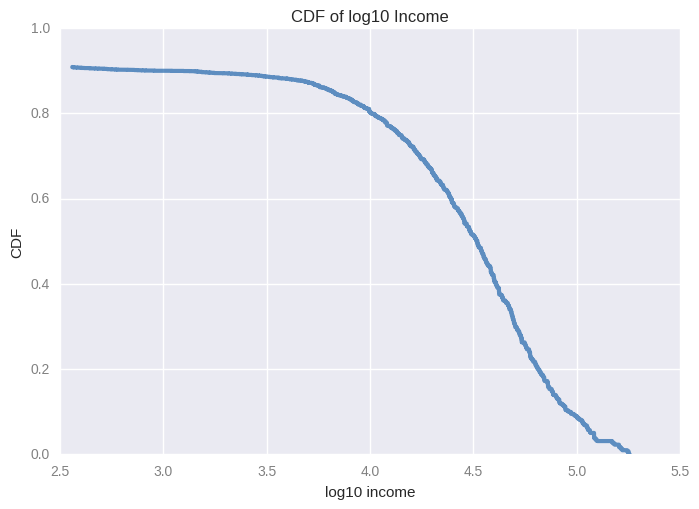

In [11]:
cdf = thinkstats2_mod.Cdf(np.log10(df.coninc))

ax = plt.axes()
for tick in ax.get_xticklabels():
    tick.set_color('gray')
for tick in ax.get_yticklabels():
    tick.set_color('gray')

thinkplot.Cdf(cdf, complement=True, color='#2166ac')
thinkplot.Config(xlabel='log10 income', ylabel='CDF', title='CDF of log10 Income')
plt.savefig('Plots/cdf_income.svg', bbox_inches='tight')
thinkplot.Show()

To visualize the relationship between income and political views, let's jitter the data and plot it with a hexbin.

In [12]:
incomes = thinkstats2_mod.Jitter(df.coninc, 20000.0)
polviews = thinkstats2_mod.Jitter(df.polviews, 0.25)

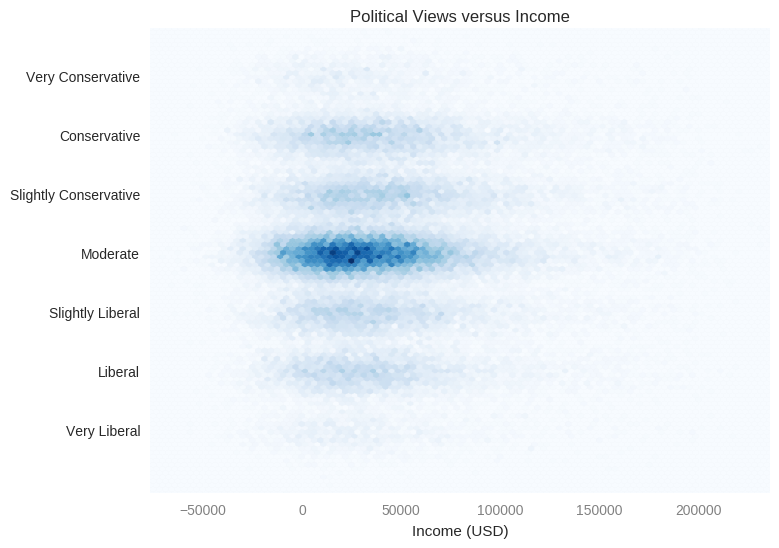

In [13]:
thinkplot.HexBin(incomes, polviews)

# Make x tick labels gray
ax = plt.axes()
for tick in ax.get_xticklabels():
    tick.set_color('gray')
    
pol_views = ('Very Liberal', 'Liberal', 'Slightly Liberal', 'Moderate', 'Slightly Conservative', 'Conservative', 'Very Conservative')
thinkplot.Config(xlabel='Income (USD)', legend=False, title='Political Views versus Income')
plt.yticks([-3, -2, -1, 0, 1, 2, 3], pol_views)
plt.savefig('Plots/income_hexbin.svg', bbox_inches='tight')
thinkplot.Show()